Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
(20, 150, 150, 3)
(20,)


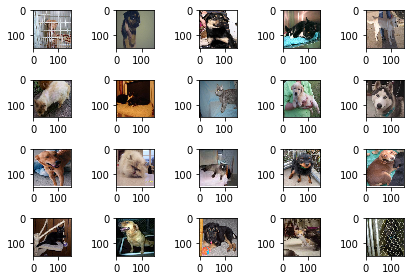

In [1]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

train_dir = './data/cat_dog_small/train'
validation_dir = './data/cat_dog_small/validation'


train_datagen  = ImageDataGenerator(rescale=1/255)
validation_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(
    train_dir, # target directory
    classes=['cats', 'dogs'],    # cat=0, dog=1 # classes를 안 잡아주면 폴더 순서대로 label이 설정됨.
    target_size=(150,150), # 정사각형태가 고정은 아니지만 보통 정사각형으로 resize함. CNN구조에 따라 resize크기는 달라짐
    batch_size=20,         # 이미지 파일을 한번에 몇개씩 변형할지 폴더 상관없이 랜덤으로 가져옴
    class_mode='binary'    # 다중분류는 categorical (default 값) - (기본 one-hot처리)
                           # 'sparse'도 이용가능
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir, # target directory
    classes=['cats', 'dogs'],    # cat=0, dog=1 # classes를 안 잡아주면 폴더 순서대로 label이 설정됨.
    target_size=(150,150), # 정사각형태가 고정은 아니지만 보통 정사각형으로 resize함. CNN구조에 따라 resize크기는 달라짐
    batch_size=20,         # 이미지 파일을 한번에 몇개씩 변형할지 폴더 상관없이 랜덤으로 가져옴
    class_mode='binary'    # 다중분류는 categorical (default 값) - (기본 one-hot처리)
                           # 'sparse'도 이용가능
)

# generator를 이용해보기
# generator는 data를 끊임없이 생성함. for문을 잘 못 돌리면 무한루프에 걸림.
for x_data, t_data in train_generator:
    print(x_data.shape) # (20, 150, 150, 3)
    print(t_data.shape) # (20,)
    break;

# 그림 이미지를 matplotlib을 이용해서 출력
fig = plt.figure()
fig_arr = list()

for i in range(20):
    fig_arr.append(fig.add_subplot(4,5,i+1))

for data_batch, label_batch in train_generator:
    for idx, img_data in enumerate(data_batch):
        fig_arr[idx].imshow(img_data)
    break;

fig.tight_layout()
plt.show()

# 다음 단계는 CNN을 구성하고 학습을 시키는 단계
# 이미지 크기가 크기 때문에 conv layer와 pooling layer를 늘려줘야 함.

In [5]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

model = Sequential()
model.add(Conv2D(filters=32,
                 kernel_size=(3,3),
                 activation='relu',
                 input_shape=(150,150,3)))

model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=64,
                 kernel_size=(3,3),
                 activation='relu'))

model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=128,
                 kernel_size=(3,3),
                 activation='relu'))

model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=128,
                 kernel_size=(3,3),
                 activation='relu'))

model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(units=512,
                activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(units=1,
                activation='sigmoid'))
print(model.summary())

model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_generator,
                    steps_per_epoch=50, # 1epoch 돌 때 몇번 데이터를 가지고 올것인지
                    epochs=50,   # 전체 데이터를 몇번 epoch돌거냐
                    validation_data = validation_generator,
                    validation_steps=50
                    )

ResourceExhaustedError: OOM when allocating tensor with shape[6272,512] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:RandomUniform]

In [ ]:
# history 객체를 조사하면 과대적합이 발생했는지 등을 알 수 있음.
print(history.history)
print(history.history.keys())

train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(train_acc, color='r', label='training accuracy') # label은 범례
plt.plot(val_acc, color='b', label='validation accuracy')
plt.legend()  #  범례 표시
# plt.show() # 15 epochs부터는 validation data가 acc이 증가하지 않음.

plt.plot(train_loss, color='r', label='training loss') # label은 범례
plt.plot(val_loss, color='b', label='validation loss')
plt.legend()  #  범례 표시
plt.show() # 15 epochs부터는 validation loss가 줄지 않고 늘어남 (학습의 의미가 없음.)
# 그래프를 보니 과대적합이 발생하는 것을 알 수 있음!
# 데이터가 적기 때문에 overfitting이 발생할 수 밖에 없는 환경임.
